In [1]:
!pip install tqdm

In [23]:
!pip install plotly==4.1.0

     |████████████████████████████████| 7.1MB 12.8MB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-cp36-none-any.whl size=11429 sha256=4eeadd7986dfff2714dab0580c43b773cd89a1b68d987df369be322d0eb7c367
  Stored in directory: /home/ao1584/.cache/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying


In [24]:
#data processing
import pandas as pd
import numpy as np
import math as math
from tqdm import tqdm
import collections

#visualizations
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

#models
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#data manipulation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [2]:
filename = "~/Data/gd1_in_gaia.h5"
dataset = pd.read_hdf(filename, 'df')

#### Add wavelength as feature for color analysis

In [61]:
dataset['c'] = dataset.g_bp - dataset.g_rp
dataset['wavelength'] = 2 - 1.88 / math.pi * (0.331 + .572 * dataset.c - 0.014 * (dataset.c)**2+ 0.045 * (dataset.c)**3).apply(math.atan)
#we want wavelengths in nanometers
dataset['wavelength'] = 1000 / dataset['wavelength']

In [67]:
def wavelength_to_rgb(wavelength, gamma=0.8):

    '''This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    '''

    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    R *= 255
    G *= 255
    B *= 255
    return (int(R), int(G), int(B))

In [65]:
wavelength = list(dataset.wavelength)
red_rgb = []
blue_rgb = []
green_rgb = []

for i in tqdm(wavelength):
    r,g,b = wavelength_to_rgb(i, gamma = 0.8)
    red_rgb.append(r)
    green_rgb.append(g)
    blue_rgb.append(b)

dataset['red_rgb'] = red_rgb
dataset['blue_rgb'] = blue_rgb
dataset['green_rgb'] = green_rgb

100%|██████████| 7079553/7079553 [00:21<00:00, 325005.43it/s]


In [66]:
dataset.columns.sort_values()

Index(['astrometric_chi2_al_x', 'astrometric_chi2_al_y',
       'astrometric_n_good_obs_al_x', 'astrometric_n_good_obs_al_y',
       'blue_rgb', 'bp', 'bp_g', 'bp_rp', 'c', 'dec', 'dec_parallax_corr',
       'dec_pmdec_corr', 'dec_pmra_corr', 'distance', 'distance_std', 'g',
       'g_bp', 'g_rp', 'gi_cmd_mask', 'green_rgb', 'parallax',
       'parallax_error', 'parallax_error_x', 'parallax_error_y',
       'parallax_over_error', 'parallax_pmdec_corr', 'parallax_pmra_corr',
       'parallax_x', 'parallax_y', 'phi1', 'phi2',
       'phot_bp_mean_flux_over_error', 'phot_bp_rp_excess_factor',
       'phot_g_mean_flux_over_error', 'phot_g_mean_mag',
       'phot_rp_mean_flux_over_error', 'pm_mask', 'pm_phi1_cosphi2',
       'pm_phi1_cosphi2_no_reflex', 'pm_phi2', 'pm_phi2_no_reflex',
       'pmdec_error_x', 'pmdec_error_y', 'pmdec_x', 'pmdec_y', 'pmra_error_x',
       'pmra_error_y', 'pmra_pmdec_corr', 'pmra_x', 'pmra_y', 'ra',
       'ra_parallax_corr', 'ra_pmdec_corr', 'ra_pmra_corr', 'r

### Supervised Analysis
#### Note: code is complaining in red but its tears are useless; the code works

In [77]:
#separate the data points that belong to GD1
dataset_gd1 = dataset[dataset['pm_mask'] == True]
dataset_gd1 = dataset_gd1[dataset_gd1['gi_cmd_mask'] == True]
dataset_gd1 = dataset_gd1[dataset_gd1['stream_track_mask'] == True]
dataset_gd1['in_gd1'] = 1

#separate the data points that do not belong to GD1
dataset_nongd = dataset[(dataset['pm_mask']== False) | (dataset['gi_cmd_mask'] == False) | (dataset['stream_track_mask'] == False)]
dataset_nongd['in_gd1'] = 0

/scratch/ao1584/myjupyter/ve2/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 0, 'pmra_x')

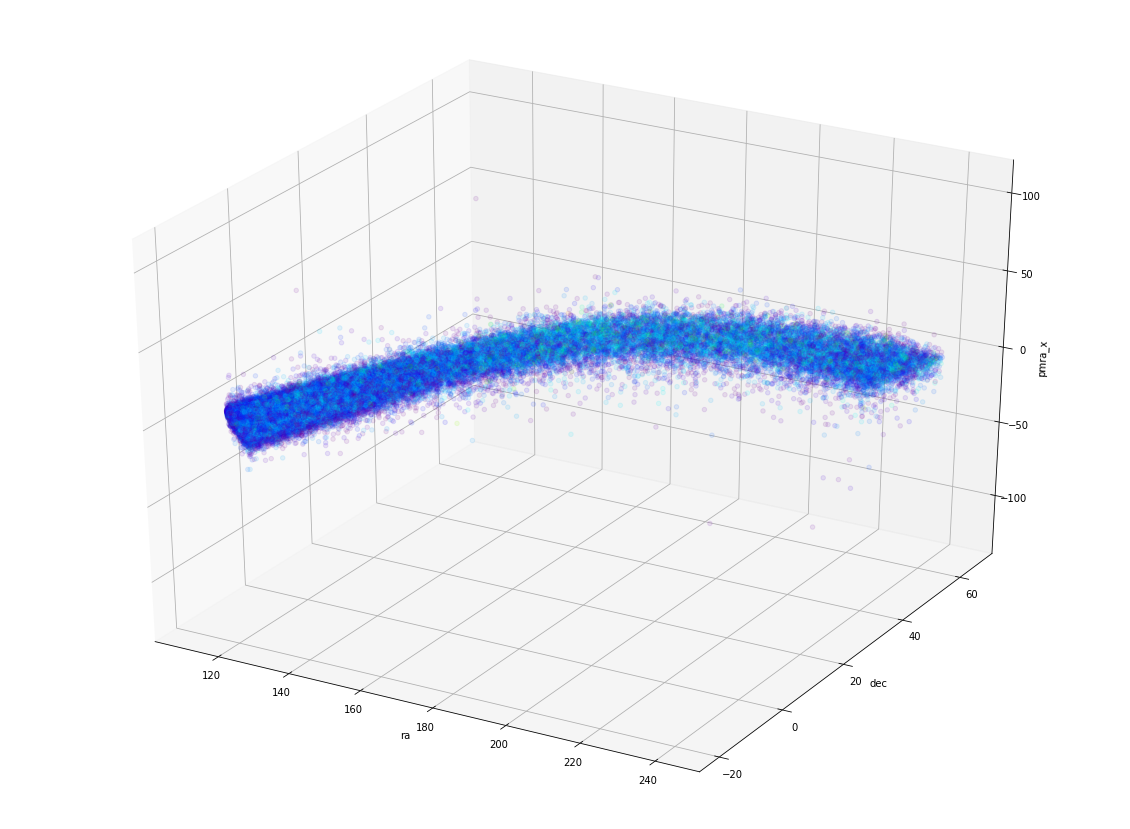

In [81]:
fig = plt.figure(figsize = (20,15))
ax = fig.add_subplot(111, projection='3d')
dataset_color = dataset.sample(100000)
ax.scatter(dataset_color.ra, dataset_color.dec, dataset_color.pmra_x, c = dataset_color[['red_rgb', 'green_rgb', 'blue_rgb']]/255, alpha = 0.1, zorder = 5)
ax.set_xlabel('ra')
ax.set_ylabel('dec')
ax.set_zlabel('pmra_x')

Text(0.5, 0, 'pmra_x')

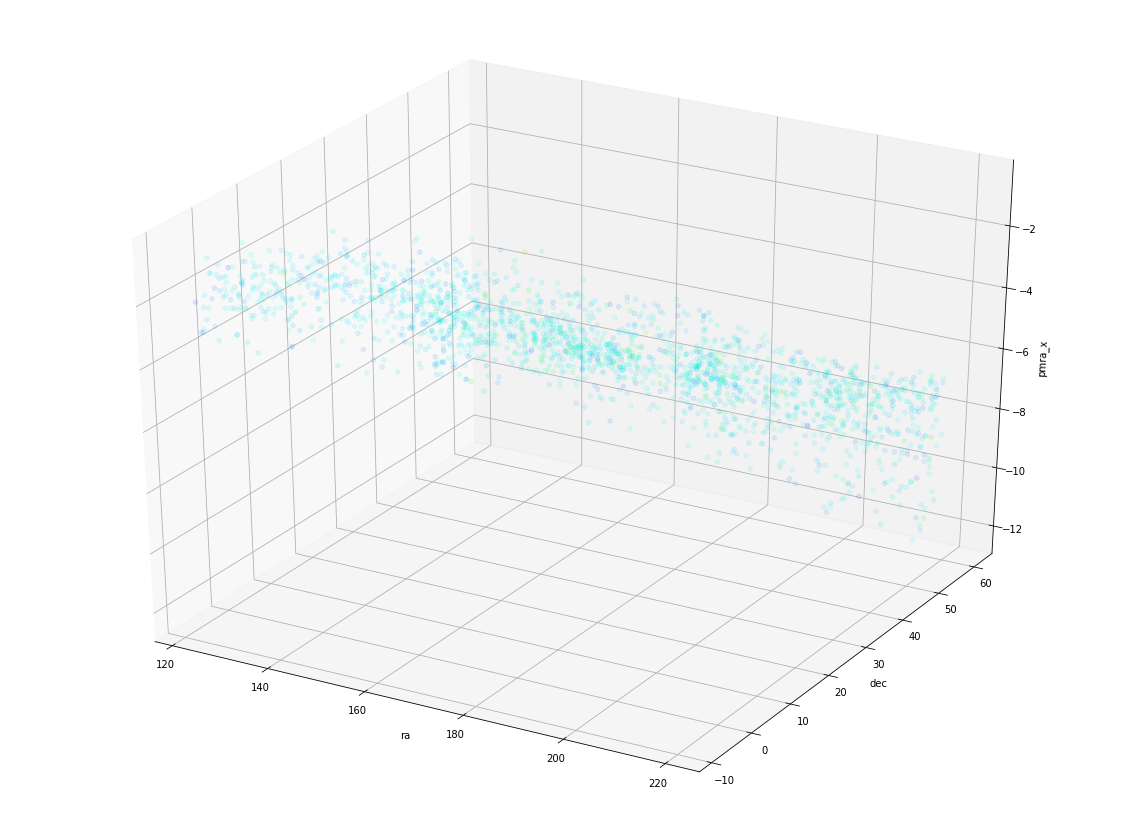

In [80]:
fig = plt.figure(figsize = (20,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset_gd1.ra, dataset_gd1.dec, dataset_gd1.pmra_x, c = dataset_gd1[['red_rgb', 'green_rgb', 'blue_rgb']]/255, alpha = 0.1, zorder = 5)
ax.set_xlabel('ra')
ax.set_ylabel('dec')
ax.set_zlabel('pmra_x')

(-13, 3)

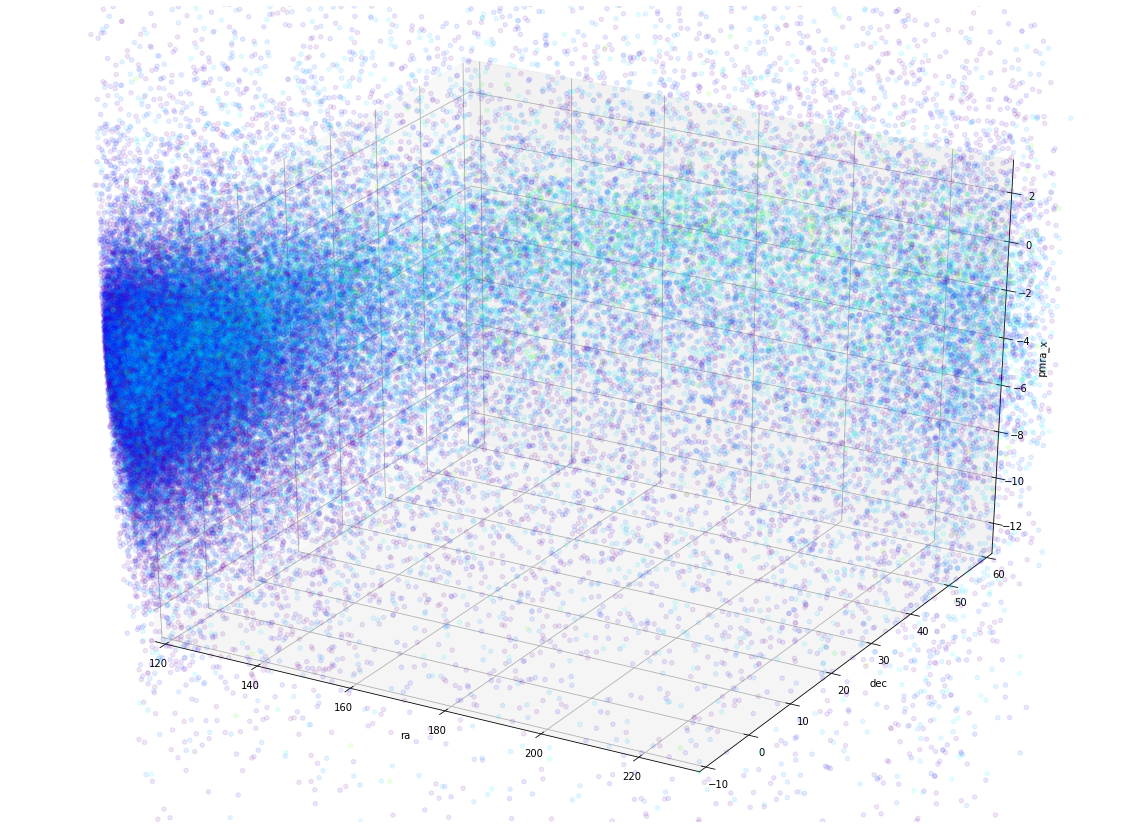

In [84]:
fig = plt.figure(figsize = (20,15))
ax = fig.add_subplot(111, projection='3d')
dataset_color = dataset.sample(100000)
ax.scatter(dataset_color.ra, dataset_color.dec, dataset_color.pmra_x, c = dataset_color[['red_rgb', 'green_rgb', 'blue_rgb']]/255, alpha = 0.1, zorder = 5)
ax.set_xlabel('ra')
ax.set_ylabel('dec')
ax.set_zlabel('pmra_x')

ax.set_xlim3d(120, 230)
ax.set_ylim3d(-10, 60)
ax.set_zlim3d(-13,3)

Text(0.5, 0, 'pmra_x')

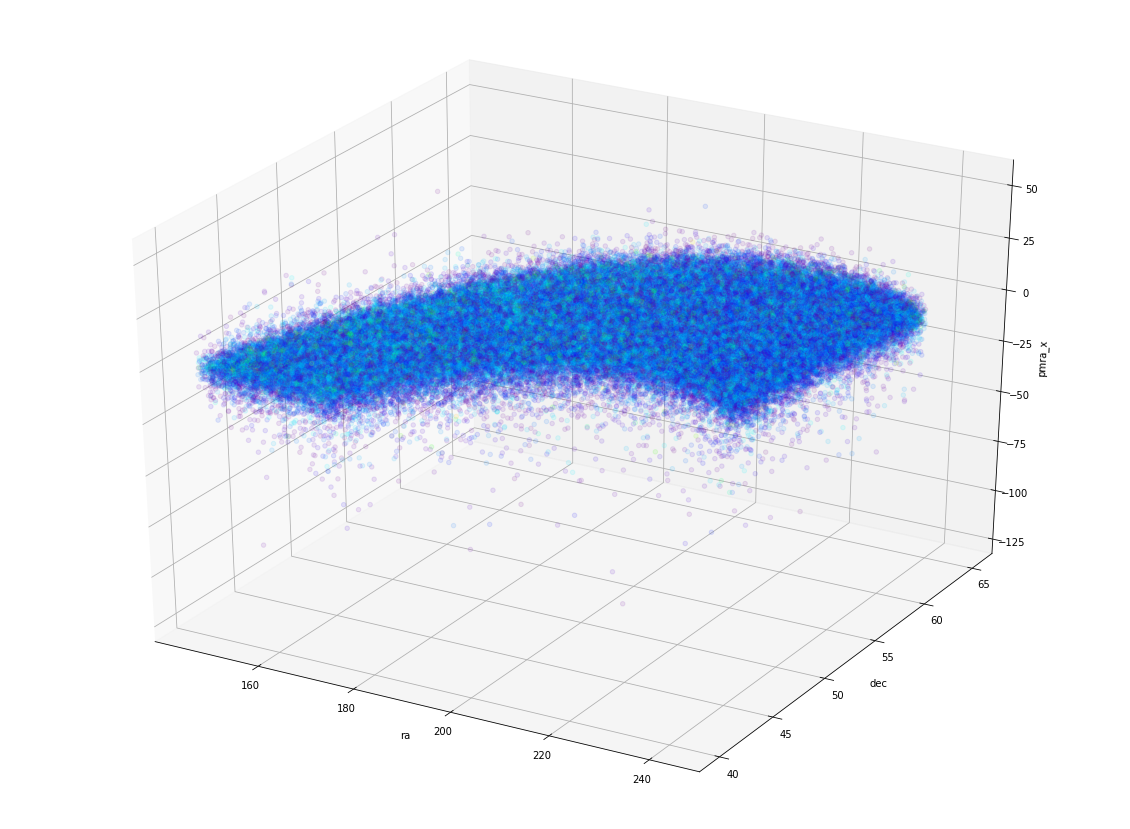

In [108]:



fig = plt.figure(figsize = (20,15))
ax = fig.add_subplot(111, projection='3d')
dataset_density = dataset[(dataset.ra > 120) & (dataset.dec > 40 )]
dataset_density = dataset_density.sample(100000)
ax.scatter(dataset_density.ra, dataset_density.dec, dataset_density.pmra_x, c = dataset_density[['red_rgb', 'green_rgb', 'blue_rgb']]/255, alpha = 0.1, zorder = 5)
ax.set_xlabel('ra')
ax.set_ylabel('dec')
ax.set_zlabel('pmra_x')

In [122]:
#for point sin dataset_density

#separate the data points that belong to GD1
dataset_gd1_b = dataset_density[dataset_density['pm_mask'] == True]
dataset_gd1_b = dataset_gd1_b[dataset_gd1_b['gi_cmd_mask'] == True]
dataset_gd1_b = dataset_gd1_b[dataset_gd1_b['stream_track_mask'] == True]
dataset_gd1_b['in_gd1'] = 1

#separate the data points that do not belong to GD1
dataset_nongd_b = dataset_density[(dataset_density['pm_mask']== False) | (dataset_density['gi_cmd_mask'] == False) | (dataset_density['stream_track_mask'] == False)]
dataset_nongd_b['in_gd1'] = 0

#select 90% of the GD1 points and a small percentage of the non-GD1 points to be part of the training data
perc_gd1_b = 0.9
msk_1b = np.random.rand(len(dataset_gd1_b)) < perc_gd1_b

train_1_b = dataset_gd1_b[msk_1b]
test_1_b = dataset_gd1_b[~msk_1b]

perc_nongd1_b = 0.0001
msk_2b = np.random.rand(len(dataset_nongd_b)) < perc_nongd1_b

train_2_b = dataset_nongd_b[msk_2b]
test_2_b = dataset_nongd_b[~msk_2b]

print(len(train_1_b), len(test_1_b), len(train_2_b), len(test_2_b))

#combine the two training data sets into a proper training and obtain X_train, X_test, y_train, y_test
training_data_b = train_1_b.append(train_2_b, ignore_index = False)
#X_train = training_data[['ra', 'dec', 'pmra_x', 'vx', 'vy', 'vz']]
X_train = training_data_b[['ra', 'dec', 'pmra_x', 'pmdec_x', 'g', 'bp', 'rp','vx', 'vy', 'vz', 'wx', 'wy', 'wz']]
y_train = training_data_b['in_gd1']

testing_data_b = test_1_b.append(test_2_b, ignore_index = False)
#X_test = testing_data[['ra', 'dec', 'pmra_x', 'vx', 'vy', 'vz']]
X_test = testing_data_b[['ra', 'dec', 'pmra_x', 'pmdec_x', 'g', 'bp', 'rp', 'vx', 'vy', 'vz', 'wx', 'wy', 'wz']]
y_test = testing_data_b['in_gd1']


97 16 8 99879


/scratch/ao1584/myjupyter/ve2/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [117]:
print(len(X_test), len(X_train), len(y_test), len(y_train))

99911 89 99911 89


Text(0.5, 0, 'blue')

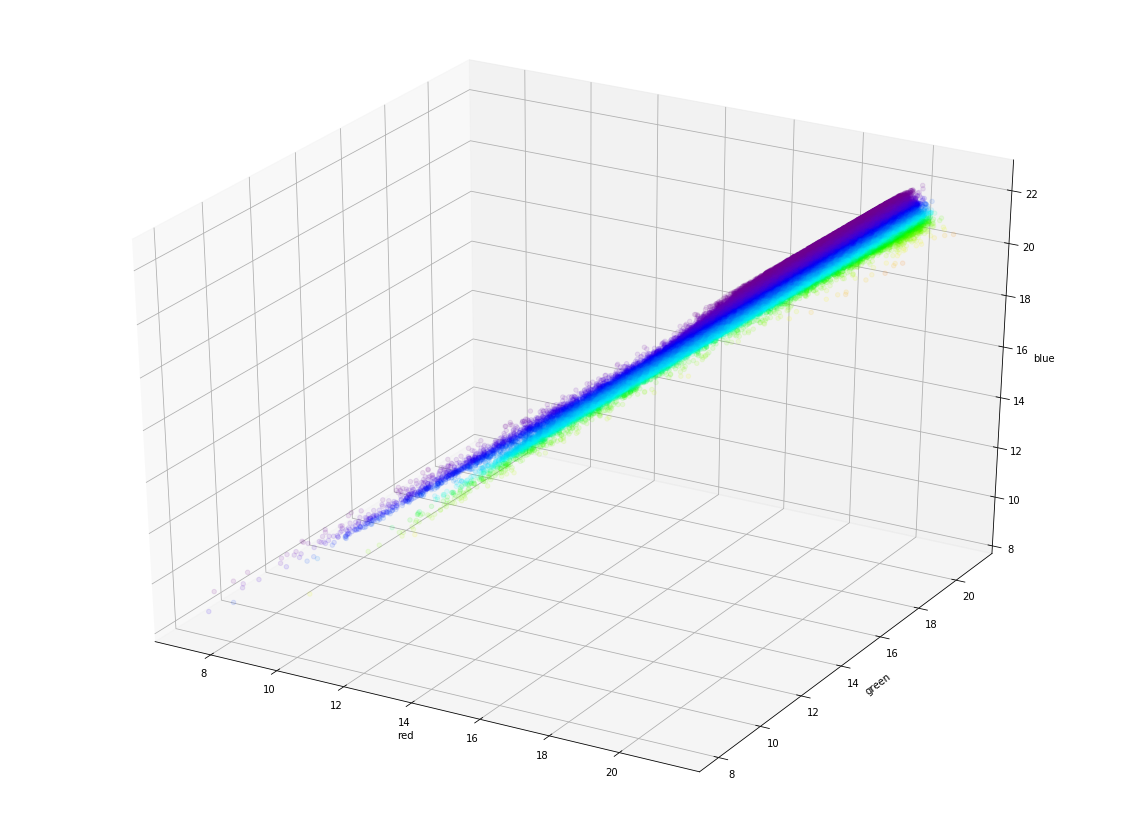

In [85]:
fig = plt.figure(figsize = (20,15))
ax = fig.add_subplot(111, projection='3d')
dataset_color = dataset.sample(100000)
ax.scatter(dataset_color.rp, dataset_color.g, dataset_color.bp, c = dataset_color[['red_rgb', 'green_rgb', 'blue_rgb']]/255, alpha = 0.1, zorder = 5)
ax.set_xlabel('red')
ax.set_ylabel('green')
ax.set_zlabel('blue')

Text(0.5, 0, 'blue')

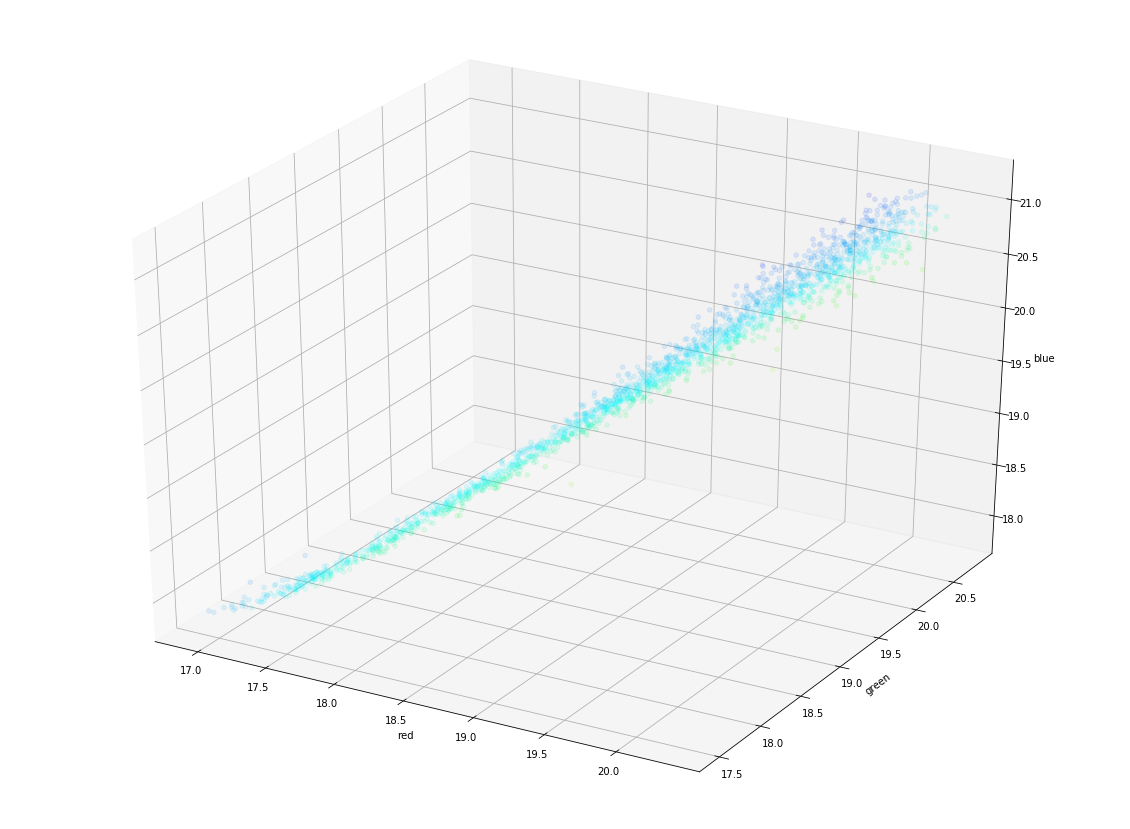

In [86]:
fig = plt.figure(figsize = (20,15))
ax = fig.add_subplot(111, projection='3d')
dataset_color = dataset.sample(100000)
ax.scatter(dataset_gd1.rp, dataset_gd1.g, dataset_gd1.bp, c = dataset_gd1[['red_rgb', 'green_rgb', 'blue_rgb']]/255, alpha = 0.1, zorder = 5)
ax.set_xlabel('red')
ax.set_ylabel('green')
ax.set_zlabel('blue')

Text(0.5, 0, 'pmra_x')

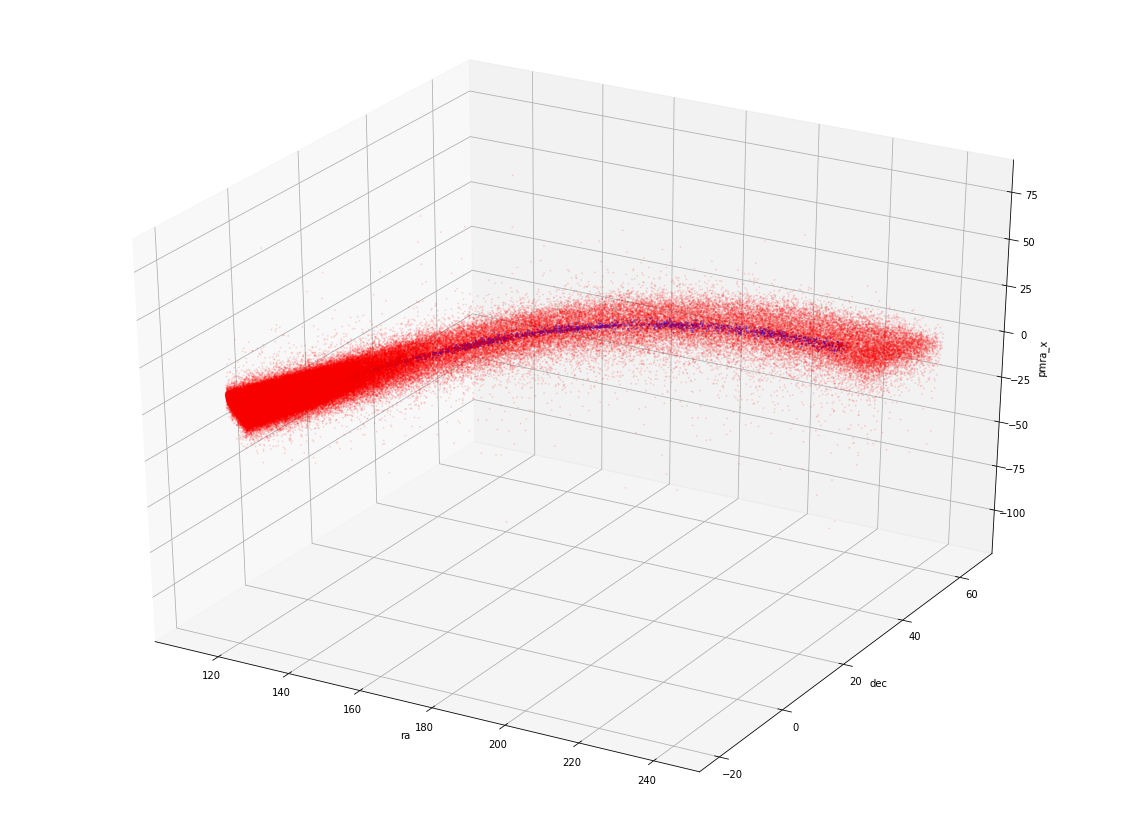

In [60]:
#plot in ra and dec space the GD1 points and some of the non-GD1 points
fig = plt.figure(figsize = (20,15))
ax = fig.add_subplot(111, projection='3d')

#
dataset_nongd_plot = dataset_nongd.sample(round(0.03*len(dataset_nongd)))
ax.scatter(dataset_nongd_plot['ra'], dataset_nongd_plot['dec'], dataset_nongd_plot['pmra_x'], s = 1, c = 'r', alpha = 0.1)
ax.scatter(dataset_gd1['ra'], dataset_gd1['dec'], dataset_gd1['pmra_x'], s = 1, c = 'b')
ax.set_xlabel('ra')
ax.set_ylabel('dec')
ax.set_zlabel('pmra_x')


In [100]:
#select 90% of the GD1 points and a small percentage of the non-GD1 points to be part of the training data
perc_gd1 = 0.8
msk_1 = np.random.rand(len(dataset_gd1)) < perc_gd1

train_1 = dataset_gd1[msk_1]
test_1 = dataset_gd1[~msk_1]

perc_nongd1 = 0.00003
msk_2 = np.random.rand(len(dataset_nongd)) < perc_nongd1

train_2 = dataset_nongd[msk_2]
test_2 = dataset_nongd[~msk_2]

In [101]:
len(train_1), len(test_1), len(train_2), len(test_2)

(1589, 390, 226, 7077348)

In [94]:
#combine the two training data sets into a proper training and obtain X_train, X_test, y_train, y_test
training_data = train_1.append(train_2, ignore_index = False)
#X_train = training_data[['ra', 'dec', 'pmra_x', 'vx', 'vy', 'vz']]
X_train = training_data[['ra', 'dec', 'pmra_x', 'pmdec_x', 'g', 'bp', 'rp','vx', 'vy', 'vz', 'wx', 'wy', 'wz']]
y_train = training_data['in_gd1']

testing_data = test_1.append(test_2, ignore_index = False)
#X_test = testing_data[['ra', 'dec', 'pmra_x', 'vx', 'vy', 'vz']]
X_test = testing_data[['ra', 'dec', 'pmra_x', 'pmdec_x', 'g', 'bp', 'rp', 'vx', 'vy', 'vz', 'wx', 'wy', 'wz']]
y_test = testing_data['in_gd1']

In [34]:
X_train.describe()

ra          dec       pmra_x            g           bp  \
count  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000   
mean    156.094764    30.668508    -5.203684    19.139797    19.418232   
std      29.196032    25.015604     3.514076     1.239651     1.209157   
min     111.907904   -19.658456   -50.502082    12.143495    12.797885   
25%     131.685689     8.857002    -7.398850    18.503673    18.780565   
50%     150.550346    37.553817    -5.605555    19.373842    19.643735   
75%     177.434743    53.703239    -2.876235    20.051226    20.302747   
max     240.460092    64.227267    15.895413    20.985342    21.457603   

                rp           vx           vy           vz           wx  \
count  2470.000000  2470.000000  2470.000000  2470.000000  2470.000000   
mean     18.580950    -0.592659     0.359871     0.469084    -4.547573   
std       1.210586     0.094952     0.382611     0.379371     4.102256   
min      11.375934    -0.810396    -0.515976    -0.336413   -39.101506   
25%      18.021074    -0.677088     0.025925     0.153969    -8.108286   
50%      18.848672    -0.608330     0.390870     0.609506    -4.372883   
75%      19.454414    -0.516743     0.737209     0.805962    -1.819124   
max      20.326118    -0.238036     0.908296     0.900526    23.565692   

                wy           wz  
count  2470.000000  2470.000000  
mean     -5.819727    -2.679790  
std       3.897381     1.847059  
min     -47.747322   -34.710717  
25%      -8.712009    -3.370811  
50%      -6.839922    -2.713691  
75%      -3.437046    -2.096843  
max       8.542040    10.472750

In [70]:
#combine all the GD1 points and non-GD1 points into a new dataframe
#df_knn = dataset_gd1.append(dataset_nongd, ignore_index = False)

#select the relevant variables for KNN
#X is the table of variables to classify with
#X = df_knn[['ra', 'dec', 'pmra_x', 'vx', 'vy', 'vz']]

#scale the features using standard scaler
#scaler = StandardScaler()
#scaler.fit(X)
#X = scaler.transform(X)

#y is the target variable
#y = df_knn['in_gd1']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify = y)

#### KNN Analysis

In [14]:
#precision = of all the ones predicted positive, how many are positive
#recall = of all the ones that are positive, how many were predicted positive

In [15]:
#let us define a function to run KNN for multiple k-values on our data set and evaluate the results
def knn_model(X_train, X_test, y_train, y_test, k):
    #do the KNN modeling
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc

In [16]:
k_options = [2,3,4,5,6,7]
precisions = []
recalls = []
accuracies = []
aucs = []

#run KNN for every k-value
for k in k_options:
    precision_k, recall_k, accuracy_k, auc_k = knn_model(X_train, X_test, y_train, y_test, k)
    precisions.append(precision_k)
    recalls.append(recall_k)
    accuracies.append(accuracy_k)
    aucs.append(auc_k)
    print('k = ' + str(k) + ' is done ...')

k = 2 is done ...
k = 3 is done ...
k = 4 is done ...
k = 5 is done ...
k = 6 is done ...
k = 7 is done ...


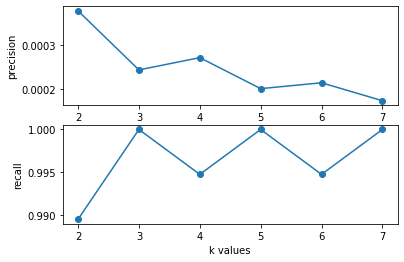

In [19]:
#visualize the KNN metrics
plt.subplot(2, 1, 1)
plt.plot(k_options, precisions, 'o-')
plt.xlabel('k values')
plt.ylabel('precision')

plt.subplot(2, 1, 2)
plt.plot(k_options, recalls, 'o-')
plt.xlabel('k values')
plt.ylabel('recall')

plt.show()

Text(0, 0.5, 'auc')

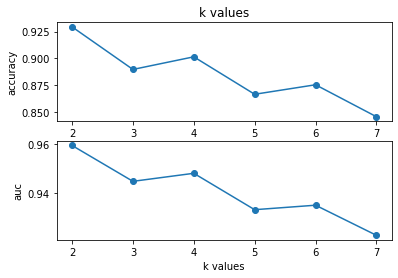

In [20]:
plt.subplot(2, 1, 1)
plt.plot(k_options, accuracies, 'o-')
plt.title('k values')
plt.ylabel('accuracy')

plt.subplot(2, 1, 2)
plt.plot(k_options, aucs, 'o-')
plt.xlabel('k values')
plt.ylabel('auc')

#### Logistic Regression Analysis

In [102]:
#let us define a function to run logistic regression on our data set and evaluate the results
def log_reg_model(X_train, X_test, y_train, y_test):
    #do the logistic regression modeling
    log_reg = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000, multi_class='warn').fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc

precision_log_reg, recall_log_reg, accuracy_log_reg, auc_log_reg = log_reg_model(X_train, X_test, y_train, y_test)

#print results
print('The precision of our logistic regression model is: ' + str(precision_log_reg))
print('The recall of our logistic regression model is: ' + str(recall_log_reg))
print('The accuracy of our logistic regression model is: ' + str(accuracy_log_reg))
print('The AUC of our logistic regression model is: ' + str(auc_log_reg))

The precision of our logistic regression model is: 0.00020860388533779962
The recall of our logistic regression model is: 1.0
The accuracy of our logistic regression model is: 0.8828462394158575
The AUC of our logistic regression model is: 0.9414216878296995


In [123]:
#We re-run our logistic regression for the less dense model.
precision_log_reg_dens, recall_log_reg_dens, accuracy_log_reg_dens, auc_log_reg_dens = log_reg_model(X_train, X_test, y_train, y_test)

#print results
print('The precision of our logistic regression model is: ' + str(precision_log_reg_dens))
print('The recall of our logistic regression model is: ' + str(recall_log_reg_dens))
print('The accuracy of our logistic regression model is: ' + str(accuracy_log_reg_dens))
print('The AUC of our logistic regression model is: ' + str(auc_log_reg_dens))

The precision of our logistic regression model is: 0.0004320120963386975
The recall of our logistic regression model is: 1.0
The accuracy of our logistic regression model is: 0.6294108814254967
The AUC of our logistic regression model is: 0.8146757576667768


#### Plotting color profile of stars in selected data set

In [62]:
min_g = .74 * max(dataset.g)
max_g = max(dataset.g)
min_b = .7 * max(dataset.bp)
max_b = max(dataset.bp)
min_r = .77  * max(dataset.rp)
max_r = max(dataset.rp)

dataset['green_val'] = (dataset['g'] - min_g)/ (max_g - min_g)# * 255
dataset['blue_val'] = (dataset['bp'] - min_b)/ (max_b - min_b)# * 255
dataset['red_val'] = (dataset['rp'] - min_r)/ (max_r - min_r)# * 255

dataset['green_val'] = np.where(dataset.green_val < 0, 0, dataset.green_val)
dataset['blue_val'] = np.where(dataset.blue_val < 0, 0, dataset.blue_val)
dataset['red_val'] = np.where(dataset.red_val < 0, 0, dataset.red_val)


#bp = blue color, #rp = red color, #g = green color
dataset_new = dataset[['x', 'y', 'z', 'green_val', 'blue_val', 'red_val']]
dataset['c'] = dataset.g_bp - dataset.g_rp
dataset['wavelength'] = 2 - 1.88 / math.pi * (0.331 + .572 * dataset.c - 0.014 * (dataset.c)**2+ 0.045 * (dataset.c)**3).apply(math.atan)
#we want wavelengths in nanometers
dataset['wavelength'] = 1000 / dataset['wavelength']



In [87]:
dataset_gd1 = dataset[dataset['pm_mask'] == True]
dataset_gd1 = dataset_gd1[dataset_gd1['gi_cmd_mask'] == True]
dataset_gd1 = dataset_gd1[dataset_gd1['stream_track_mask'] == True]

In [71]:
wavelength = list(dataset.wavelength)
red_rgb = []
blue_rgb = []
green_rgb = []

for i in tqdm(wavelength):
    r,g,b = wavelength_to_rgb(i, gamma = 0.8)
    red_rgb.append(r)
    green_rgb.append(g)
    blue_rgb.append(b)

dataset['red_rgb'] = red_rgb
dataset['blue_rgb'] = blue_rgb
dataset['green_rgb'] = green_rgb   


100%|██████████| 7079553/7079553 [00:16<00:00, 425597.24it/s]


In [72]:
dataset['red_rgb'] = red_rgb
dataset['blue_rgb'] = blue_rgb
dataset['green_rgb'] = green_rgb

In [74]:
dataset_new = dataset[['x', 'y', 'z', 'red_rgb', 'blue_rgb', 'green_rgb']]

In [65]:
def wavelength_to_rgb(wavelength, gamma=0.8):

    '''This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    '''

    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    R *= 255
    G *= 255
    B *= 255
    return (int(R), int(G), int(B))

#Visualize all our data points positionally
#Let us use blue markers for our GD1 stars and red markers for our non-GD1 stars
fig = plt.figure(figsize = (20,15))
ax = fig.add_subplot(111, projection='3d')

dataset_test = dataset_new[dataset.wavelength > 450]#.sample(10000)

ax.scatter(dataset_test.x, dataset_test.y, dataset_test.z, c = dataset_test[['red_rgb', 'green_rgb', 'blue_rgb']]/255, alpha = 0.1, zorder = 5)


Text(0.5, 0, 'Z Label')

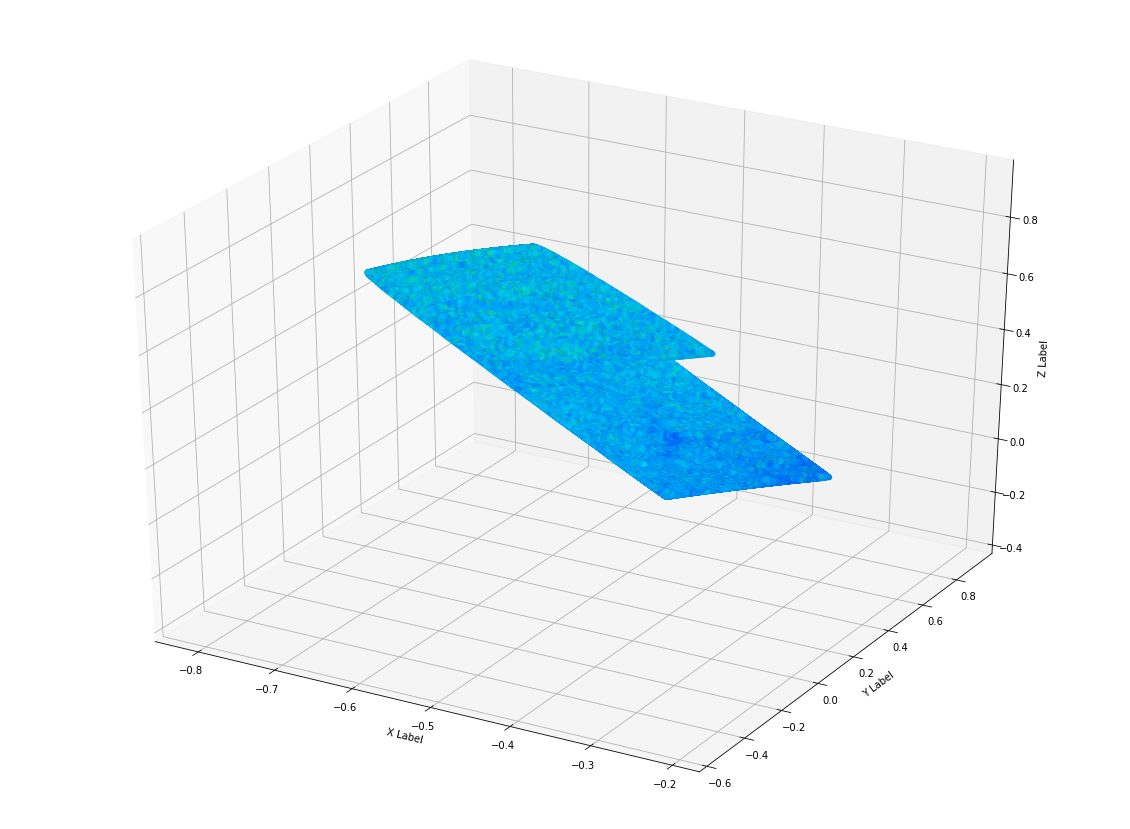

In [86]:
#Visualize all our data points positionally
#Let us use blue markers for our GD1 stars and red markers for our non-GD1 stars
fig = plt.figure(figsize = (20,15))
ax = fig.add_subplot(111, projection='3d')

dataset_test = dataset_new[dataset.wavelength > 450]#.sample(10000)

ax.scatter(dataset_test.x, dataset_test.y, dataset_test.z, c = dataset_test[['red_rgb', 'green_rgb', 'blue_rgb']]/255, alpha = 0.1, zorder = 5)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

In [40]:
dataset_new.describe()

x            y            z    green_val     blue_val  \
count 7,079,553.00 7,079,553.00 7,079,553.00 7,079,553.00 7,079,553.00   
mean         -0.53         0.67         0.05         0.84         0.79   
std           0.10         0.36         0.37         0.11         0.10   
min          -0.81        -0.53        -0.34         0.11         0.12   
25%          -0.60         0.72        -0.21         0.77         0.73   
50%          -0.52         0.81        -0.12         0.86         0.81   
75%          -0.46         0.86         0.18         0.93         0.88   
max          -0.21         0.91         0.91         1.00         1.00   

           red_val  
count 7,079,553.00  
mean          0.77  
std           0.10  
min           0.08  
25%           0.71  
50%           0.79  
75%           0.85  
max           1.00

(array([2.00000e+00, 1.00000e+00, 6.00000e+00, 6.00000e+00, 2.20000e+01,
        3.30000e+01, 8.00000e+01, 1.41000e+02, 1.96000e+02, 3.04000e+02,
        4.25000e+02, 6.88000e+02, 1.09100e+03, 1.73900e+03, 2.41600e+03,
        2.88000e+03, 3.62300e+03, 4.56800e+03, 5.73800e+03, 7.18700e+03,
        9.32300e+03, 1.18550e+04, 1.54950e+04, 2.09400e+04, 2.88850e+04,
        3.82760e+04, 4.91990e+04, 6.24340e+04, 7.88640e+04, 9.64800e+04,
        1.16974e+05, 1.40787e+05, 1.64554e+05, 1.89506e+05, 2.17587e+05,
        2.45701e+05, 2.73780e+05, 3.03072e+05, 3.31270e+05, 3.59935e+05,
        3.86677e+05, 4.11679e+05, 4.31477e+05, 4.47978e+05, 4.58537e+05,
        4.68128e+05, 4.76575e+05, 4.90092e+05, 4.80103e+05, 2.42244e+05]),
 array([0.1110644 , 0.12884311, 0.14662182, 0.16440053, 0.18217925,
        0.19995796, 0.21773667, 0.23551538, 0.25329409, 0.27107281,
        0.28885152, 0.30663023, 0.32440894, 0.34218765, 0.35996637,
        0.37774508, 0.39552379, 0.4133025 , 0.43108121, 0.448859

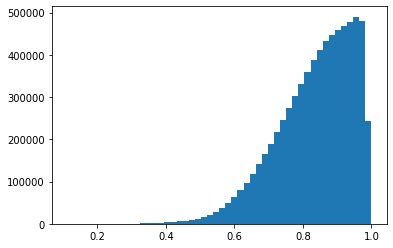

In [39]:
plt.hist(dataset.green_val, bins = 50)

(array([1.00000e+00, 0.00000e+00, 1.00000e+00, 2.00000e+00, 7.00000e+00,
        9.00000e+00, 2.60000e+01, 5.70000e+01, 1.04000e+02, 1.83000e+02,
        3.61000e+02, 5.16000e+02, 8.92000e+02, 1.65100e+03, 2.49500e+03,
        3.15800e+03, 4.18900e+03, 5.46300e+03, 7.32900e+03, 9.77200e+03,
        1.30100e+04, 1.82280e+04, 2.49690e+04, 3.56650e+04, 4.80430e+04,
        6.22470e+04, 8.03620e+04, 9.95820e+04, 1.22010e+05, 1.47231e+05,
        1.74347e+05, 2.01099e+05, 2.31515e+05, 2.59942e+05, 2.89247e+05,
        3.20190e+05, 3.52096e+05, 3.83378e+05, 4.18899e+05, 4.51448e+05,
        4.84434e+05, 5.14094e+05, 5.48713e+05, 5.87774e+05, 5.82036e+05,
        4.19675e+05, 1.53094e+05, 1.92950e+04, 6.93000e+02, 2.10000e+01]),
 array([  0.  ,   5.12,  10.24,  15.36,  20.48,  25.6 ,  30.72,  35.84,
         40.96,  46.08,  51.2 ,  56.32,  61.44,  66.56,  71.68,  76.8 ,
         81.92,  87.04,  92.16,  97.28, 102.4 , 107.52, 112.64, 117.76,
        122.88, 128.  , 133.12, 138.24, 143.36, 148.

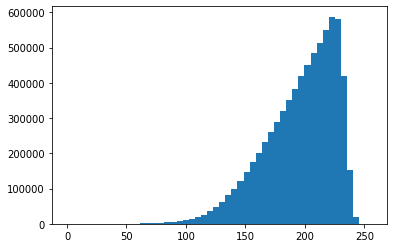

In [22]:
plt.hist(dataset.blue_val, bins = 50)


(array([1.00000e+00, 3.00000e+00, 6.00000e+00, 1.20000e+01, 3.00000e+01,
        6.60000e+01, 1.14000e+02, 1.88000e+02, 2.85000e+02, 3.97000e+02,
        6.72000e+02, 9.82000e+02, 1.63700e+03, 2.44400e+03, 2.97800e+03,
        3.96100e+03, 5.00700e+03, 6.08200e+03, 7.78900e+03, 9.98300e+03,
        1.26850e+04, 1.69700e+04, 2.40610e+04, 3.32280e+04, 4.52730e+04,
        6.02960e+04, 7.96300e+04, 1.01653e+05, 1.27938e+05, 1.59498e+05,
        1.92492e+05, 2.29287e+05, 2.69244e+05, 3.09707e+05, 3.53189e+05,
        3.93679e+05, 4.33435e+05, 4.66678e+05, 5.00313e+05, 5.27710e+05,
        5.57793e+05, 5.93396e+05, 6.33150e+05, 5.47853e+05, 2.79532e+05,
        7.76780e+04, 9.65700e+03, 8.07000e+02, 8.20000e+01, 2.00000e+00]),
 array([  0.  ,   5.12,  10.24,  15.36,  20.48,  25.6 ,  30.72,  35.84,
         40.96,  46.08,  51.2 ,  56.32,  61.44,  66.56,  71.68,  76.8 ,
         81.92,  87.04,  92.16,  97.28, 102.4 , 107.52, 112.64, 117.76,
        122.88, 128.  , 133.12, 138.24, 143.36, 148.

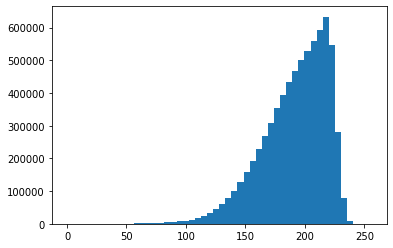

In [21]:
plt.hist(dataset.red_val, bins = 50)

In [4]:
dataset_test_val = dataset[['pmra_x', 'pmra_y', 'pmdec_x', 'pmdec_y']]
dataset_test_val.head()

pmra_x    pmra_y   pmdec_x   pmdec_y
0 -4.570898 -4.570898  2.667068  2.667068
1 -0.182367 -0.182367 -1.928052 -1.928052
2  2.706258  2.706258  0.876301  0.876301
3 -3.412101 -3.412101 -9.138783 -9.138783
4 -4.019078 -4.019078 -7.425035 -7.425035

In [7]:
dataset_test_val = dataset[['g_rp', 'g_bp', 'g']]
dataset_test_val.head(100)

g_rp      g_bp          g
0   0.646324 -0.535103  17.552580
1   0.400768 -0.257050  17.626762
2   0.586554 -0.478157  17.460999
3   0.592878 -0.411474  16.796415
4   0.738855 -0.523422  20.563059
..       ...       ...        ...
95  1.162779 -0.666491  19.635885
96  0.504639 -0.354776  16.244095
97  0.609840 -0.246481  19.966881
98  0.537479 -0.420479  17.942242
99  0.870396 -0.721430  17.878321

[100 rows x 3 columns]

## use 'ra', 'dec', 'pmra_x', and 'pmdec_x' for first pass at DBSCAN

In [5]:
dataset_dbscan = dataset[['ra', 'dec','pmra_x', 'pmdec_x']]
dataset_dbscan.head()

ra        dec    pmra_x   pmdec_x
0  149.169253  22.597692 -4.570898  2.667068
1  149.714033  22.674743 -0.182367 -1.928052
2  149.216760  22.583470  2.706258  0.876301
3  149.298995  22.471282 -3.412101 -9.138783
4  148.808499  22.259178 -4.019078 -7.425035

In [6]:
scaler = StandardScaler()
scaler.fit(dataset_dbscan)
dataset_dbscan_scaled = scaler.transform(dataset_dbscan)
print(dataset_dbscan_scaled)

[[ 0.50593689  0.79931427 -0.54086638  0.74635133]
 [ 0.52490616  0.802588    0.49875256 -0.12705031]
 [ 0.50759108  0.79870999  1.18305189  0.40597759]
 ...
 [-0.34987406 -0.50971469  0.08285683 -0.39514272]
 [-0.36444892 -0.51005664 -0.8106525   1.29477726]
 [-0.3577725  -0.50445642 -0.23850189  0.67191849]]


In [ ]:
#this fails due to size / memory
#db = DBSCAN(eps=0.3, min_samples=2000).fit(dataset)

## Running DBSCAN on the entire data set crashes the kernel. Consider downsampling the non-GD1 data points randomly.

In [7]:
#separate the data points that belong to GD1
dataset_gd1 = dataset[dataset['pm_mask'] == True]
dataset_gd1 = dataset_gd1[dataset_gd1['gi_cmd_mask'] == True]
dataset_gd1 = dataset_gd1[dataset_gd1['stream_track_mask'] == True]

#separate the data points that do not belong to GD1
dataset_nongd = dataset[(dataset['pm_mask']== False) | (dataset['gi_cmd_mask'] == False) | (dataset['stream_track_mask'] == False)]

In [8]:
dataset_gd1_distance = dataset_gd1[['ra', 'dec','pmra_x', 'pmdec_x']]
means = dataset_gd1_distance.describe().iloc[1]

means[0]


dataset_gd1_distance['distance'] = ((means[0]-dataset_gd1_distance['ra'])**2+(means[1]-dataset_gd1_distance['dec'])**2+(means[2]-dataset_gd1_distance['pmra_x'])**2+(means[3]-dataset_gd1_distance['pmdec_x'])**2)

/scratch/ao1584/myjupyter/ve2/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [9]:
dataset_gd1_distance

ra        dec    pmra_x    pmdec_x     distance
65363    125.725791  -2.659323 -1.284922 -12.158667  3459.228659
109416   127.489637  -1.303699 -2.388286 -11.922833  3197.039495
111789   126.534141  -0.269963 -1.830900 -10.318987  3181.029556
112314   126.595622  -0.184869 -2.708172 -10.402403  3162.601107
112765   127.278916  -0.065411 -2.346544 -10.322610  3103.470328
...             ...        ...       ...        ...          ...
1398729  168.574508  50.210404 -7.318740  -9.827161   103.036873
1398819  168.565209  49.616775 -8.654472  -9.066697    96.248560
1398882  168.926104  49.822818 -8.097809 -10.685463   103.135933
1398904  166.796971  49.737743 -7.007675  -9.757877    83.632775
1399250  166.416164  51.319863 -7.481646 -10.744130   116.264146

[1979 rows x 5 columns]

899
the percentage of GD1 points that we retain is 45.426983324911575


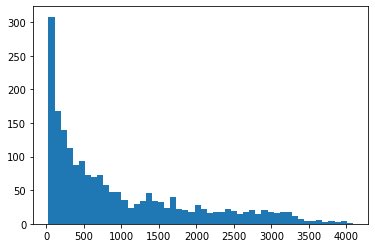

In [15]:
plt.hist(dataset_gd1_distance.distance, bins = 50)
max_gd1_distance = max(dataset_gd1_distance.distance)

#assume cutoff distance is cutoff_distance
cutoff_distance = 500
dataset_gd1_distance_2 = dataset_gd1_distance[dataset_gd1_distance.distance < cutoff_distance]
print(len(dataset_gd1_distance_2))
print('the percentage of GD1 points that we retain is ' + str(len(dataset_gd1_distance_2)/1979*100))

In [16]:
dataset_dbscan['distance2'] = ((means[0]-dataset_dbscan['ra'])**2+(means[1]-dataset_dbscan['dec'])**2+(means[2]-dataset_dbscan['pmra_x'])**2+(means[3]-dataset_dbscan['pmdec_x'])**2)
dataset_dbscan_filtered = dataset_dbscan[dataset_dbscan.distance2 < cutoff_distance]

/scratch/ao1584/myjupyter/ve2/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
print('the percentage of all points that we retain is ' + str(len(dataset_dbscan_filtered)/len(dataset)*100))
print(len(dataset_dbscan_filtered))

the percentage of all points that we retain is 6.76046919911469
478611


In [18]:
#combine the GD1 and non-GD1 points to create a realistic dataframe on which DBSCAN can be executed
#df_dbscan = dataset_gd1.append(dataset_nongd.sample(1000), ignore_index = False)
df_dbscan = dataset_dbscan_filtered
df_dbscan = df_dbscan[['ra', 'dec','pmra_x', 'pmdec_x']]
df_dbscan.head()

ra        dec     pmra_x   pmdec_x
965  150.442143  24.773738  -2.234139 -6.398935
970  151.654544  24.559993  -3.084434 -5.602138
971  151.142473  24.888963 -12.181984 -8.333864
974  151.348555  24.892126  -3.803370 -7.784712
983  150.734988  24.109515  -4.528903 -4.933537

In [19]:
#scale the features using standard scaler
scaler = StandardScaler()
scaler.fit(df_dbscan)
dataset_dbscan_scaled = scaler.transform(df_dbscan)
print(dataset_dbscan_scaled)
len(dataset_dbscan_scaled)

[[-1.15836472 -2.26739986  0.14812961 -0.05909388]
 [-1.0386804  -2.29502653 -0.01464086  0.09387163]
 [-1.08923044 -2.25250698 -1.75616868 -0.43055312]
 ...
 [ 0.45814669  1.08500974  0.4407645   1.17592366]
 [ 0.44379313  1.14563184 -1.64078616 -1.48055025]
 [ 0.52857655  1.13707091  0.3192296   0.9448057 ]]


478611

In [ ]:
#run dbscan on reduced dataset
db = DBSCAN(eps=1.8, min_samples=1500).fit(dataset_dbscan_scaled)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

In [16]:
labels_analysis = list(labels)
num_0 = labels_analysis.count(0)
num_negative_1 = labels_analysis.count(-1)
num_0, num_negative_1
#Therefore, 0 is in the cluster and negative 1 is remainder of the points

(2041, 938)

In [116]:
df_dbscan['modeled_labels'] = labels

In [117]:
df_dbscan.head()

ra       dec    pmra_x    pmdec_x  modeled_labels
65363   125.725791 -2.659323 -1.284922 -12.158667               0
109416  127.489637 -1.303699 -2.388286 -11.922833               0
111789  126.534141 -0.269963 -1.830900 -10.318987               0
112314  126.595622 -0.184869 -2.708172 -10.402403               0
112765  127.278916 -0.065411 -2.346544 -10.322610               0

In [118]:
gd1_index = dataset_gd1.index
df_dbscan_index = df_dbscan.index
actual_label = []

for i in df_dbscan_index:
    if i in gd1_index:
        actual_label.append(0)
    else:
        actual_label.append(-1)
        
df_dbscan['actual_labels'] = actual_label
        


In [119]:
df_dbscan.modeled_labels.value_counts()

 0    2207
-1     772
Name: modeled_labels, dtype: int64

In [120]:
df_dbscan.actual_labels.value_counts()

 0    1981
-1     998
Name: actual_labels, dtype: int64

In [121]:
df_dbscan

ra        dec     pmra_x    pmdec_x  modeled_labels  \
65363    125.725791  -2.659323  -1.284922 -12.158667               0   
109416   127.489637  -1.303699  -2.388286 -11.922833               0   
111789   126.534141  -0.269963  -1.830900 -10.318987               0   
112314   126.595622  -0.184869  -2.708172 -10.402403               0   
112765   127.278916  -0.065411  -2.346544 -10.322610               0   
...             ...        ...        ...        ...             ...   
1333119  216.533438  62.415074 -10.385344   3.805131              -1   
1303825  124.009389  -9.927529  -5.142956  -3.961033               0   
918596   130.309184   6.651169  -1.657888  -3.262142               0   
730113   120.607307 -12.857020  -1.003295   1.237131              -1   
871212   122.073779 -10.089503   0.542435   1.182134              -1   

         actual_labels  
65363                0  
109416               0  
111789               0  
112314               0  
112765               0  
...                ...  
1333119             -1  
1303825             -1  
918596              -1  
730113              -1  
871212              -1  

[2979 rows x 6 columns]

In [127]:
#true positives
a = len(df_dbscan[(df_dbscan.modeled_labels == 0) & (df_dbscan.actual_labels == 0 )])

In [128]:
#false positive
b = len(df_dbscan[(df_dbscan.modeled_labels == 0) & (df_dbscan.actual_labels == -1 )])

In [129]:
#true negatives
c = len(df_dbscan[(df_dbscan.modeled_labels == -1) & (df_dbscan.actual_labels == -1 )])

In [130]:
#false negative
d = len(df_dbscan[(df_dbscan.modeled_labels == -1) & (df_dbscan.actual_labels == 0 )])

In [132]:
accuracy = (a+c) / (a+b+c+d)
recall = a / (a + d)
precision = a / (a + b)

In [133]:
print(accuracy, recall, precision)

0.9006377979187646 0.9823321554770318 0.881739918441323


In [15]:
dataset_subset = dataset[['x', 'y', 'z', 'vx', 'vy', 'vz', 'wx', 'wy', 'wz', 'g_bp', 'g_rp']]

In [16]:
dataset.distance_std.describe()

count    7.079553e+06
mean     2.725450e+00
std      3.975840e+00
min      1.082110e-02
25%      4.723332e-01
50%      1.737067e+00
75%      3.512519e+00
max      2.374484e+03
Name: distance_std, dtype: float64

In [6]:
dataset_subset.describe()

x             y             z            vx            vy  \
count  7.079553e+06  7.079553e+06  7.079553e+06  7.079553e+06  7.079553e+06   
mean  -5.328728e-01  6.650263e-01  4.601894e-02 -5.328728e-01  6.650263e-01   
std    1.044840e-01  3.560622e-01  3.660216e-01  1.044840e-01  3.560622e-01   
min   -8.131475e-01 -5.333810e-01 -3.411577e-01 -8.131475e-01 -5.333810e-01   
25%   -6.025410e-01  7.161791e-01 -2.136935e-01 -6.025410e-01  7.161791e-01   
50%   -5.216390e-01  8.136161e-01 -1.179119e-01 -5.216390e-01  8.136161e-01   
75%   -4.561276e-01  8.617298e-01  1.753461e-01 -4.561276e-01  8.617298e-01   
max   -2.108210e-01  9.093330e-01  9.083652e-01 -2.108210e-01  9.093330e-01   

                 vz            wx            wy            wz          g_bp  \
count  7.079553e+06  7.079553e+06  7.079553e+06  7.079553e+06  7.079553e+06   
mean   4.601894e-02 -3.180707e-01 -1.345577e+00 -1.816736e+00 -4.480979e-01   
std    3.660216e-01  3.776223e+00  4.015359e+00  3.023008e+00  2.188547e-01   
min   -3.411577e-01 -2.411224e+02 -2.199764e+02 -9.675660e+01 -1.598055e+00   
25%   -2.136935e-01 -1.661901e+00 -1.844835e+00 -3.002494e+00 -5.796032e-01   
50%   -1.179119e-01  2.110479e-01 -2.181221e-01 -1.570461e+00 -4.278221e-01   
75%    1.753461e-01  1.564804e+00  4.852948e-01 -3.903792e-01 -3.209000e-01   
max    9.083652e-01  8.581731e+01  4.947293e+01  3.715335e+02  1.768539e+00   

               g_rp  
count  7.079553e+06  
mean   7.049657e-01  
std    2.212432e-01  
min   -8.417149e-01  
25%    5.374603e-01  
50%    6.561337e-01  
75%    8.419418e-01  
max    2.396633e+00

In [6]:
#dataset.describe()

In [6]:
dataset_subset.describe()

x             y             z            vx            vy  \
count  7.079553e+06  7.079553e+06  7.079553e+06  7.079553e+06  7.079553e+06   
mean  -5.328728e-01  6.650263e-01  4.601894e-02 -5.328728e-01  6.650263e-01   
std    1.044840e-01  3.560622e-01  3.660216e-01  1.044840e-01  3.560622e-01   
min   -8.131475e-01 -5.333810e-01 -3.411577e-01 -8.131475e-01 -5.333810e-01   
25%   -6.025410e-01  7.161791e-01 -2.136935e-01 -6.025410e-01  7.161791e-01   
50%   -5.216390e-01  8.136161e-01 -1.179119e-01 -5.216390e-01  8.136161e-01   
75%   -4.561276e-01  8.617298e-01  1.753461e-01 -4.561276e-01  8.617298e-01   
max   -2.108210e-01  9.093330e-01  9.083652e-01 -2.108210e-01  9.093330e-01   

                 vz            wx            wy            wz  
count  7.079553e+06  7.079553e+06  7.079553e+06  7.079553e+06  
mean   4.601894e-02 -3.180707e-01 -1.345577e+00 -1.816736e+00  
std    3.660216e-01  3.776223e+00  4.015359e+00  3.023008e+00  
min   -3.411577e-01 -2.411224e+02 -2.199764e+02 -9.675660e+01  
25%   -2.136935e-01 -1.661901e+00 -1.844835e+00 -3.002494e+00  
50%   -1.179119e-01  2.110479e-01 -2.181221e-01 -1.570461e+00  
75%    1.753461e-01  1.564804e+00  4.852948e-01 -3.903792e-01  
max    9.083652e-01  8.581731e+01  4.947293e+01  3.715335e+02

In [5]:
dataset_gd1 = dataset[dataset['pm_mask'] == True]
dataset_gd2 = dataset_gd1[dataset_gd1['gi_cmd_mask'] == True]
dataset_gd3 = dataset_gd2[dataset_gd2['stream_track_mask'] == True]

In [6]:
dataset_nongd = dataset[(dataset['pm_mask']== False) | (dataset['gi_cmd_mask'] == False) | (dataset['stream_track_mask'] == False)]

In [7]:
len(dataset_gd1), len(dataset_gd2), len(dataset_gd3), len(dataset_nongd)

(98446, 5913, 1979, 7077574)

In [8]:
dataset_gd3.head()

source_id_x          ra       dec  parallax_x  \
65363   4932057318482262231  125.725791 -2.659323   -0.112633   
109416  4913866998112330384  127.489637 -1.303699   -1.794033   
111789  5039950195492672272  126.534141 -0.269963   -0.099574   
112314  5039950195492674801  126.595622 -0.184869   -0.467093   
112765  5003886214101624301  127.278916 -0.065411   -0.364233   

        parallax_error_x    pmra_x  pmra_error_x    pmdec_x  pmdec_error_x  \
65363           2.033602 -1.284922      2.370146 -12.158667       1.143428   
109416          1.317352 -2.388286      1.653637 -11.922833       1.768353   
111789          0.283333 -1.830900      0.452772 -10.318987       0.256637   
112314          0.480912 -2.708172      0.872378 -10.402403       0.559001   
112765          0.455181 -2.346544      0.672108 -10.322610       0.391025   

        ra_parallax_corr  ...  pmra_error_y  pmdec_error_y       uwe  \
65363          -0.670974  ...      2.370146       1.143428  0.969147   
109416          0.334261  ...      1.653637       1.768353  0.992096   
111789          0.038211  ...      0.452772       0.256637  1.023328   
112314         -0.002237  ...      0.872378       0.559001  0.937997   
112765         -0.443896  ...      0.672108       0.391025  1.006667   

            ruwe        rlen  parallax  parallax_error  parallax_over_error  \
65363   0.947957  535.050903 -0.083633        2.033602            -0.041126   
109416  0.976311  504.489380 -1.765033        1.317352            -1.339834   
111789  1.000593  506.631958 -0.070574        0.283333            -0.249085   
112314  0.919160  505.213074 -0.438093        0.480912            -0.910964   
112765  0.985561  496.337311 -0.335233        0.455181            -0.736483   

         distance  distance_std  
65363   16.168953     19.790644  
109416  12.870770      7.136427  
111789  10.614759      2.535010  
112314  12.946384      4.299290  
112765  11.452238     10.591134  

[5 rows x 71 columns]

In [9]:
dataset_gd3_subset = dataset_gd3[['x', 'y', 'z', 'vx', 'vy', 'vz', 'wx', 'wy', 'wz']]

In [12]:
dataset_gd3_subset.head()

x         y         z        vx        vy        vz        wx  \
65363  -0.583278  0.810946 -0.046397 -0.583278  0.810946 -0.046397 -9.835885   
109416 -0.608460  0.793258 -0.022752 -0.608460  0.793258 -0.022752 -9.427270   
111789 -0.595295  0.803493 -0.004712 -0.595295  0.803493 -0.004712 -8.286194   
112314 -0.596160  0.802859 -0.003227 -0.596160  0.802859 -0.003227 -8.346495   
112765 -0.605695  0.795696 -0.001142 -0.605695  0.795696 -0.001142 -8.212041   

              wy        wz  
65363  -7.147873 -1.282156  
109416 -7.299554 -2.387049  
111789 -6.149842 -1.830859  
112314 -6.208549 -2.708144  
112765 -6.254491 -2.346541

Text(0.5, 0, 'Z Label')

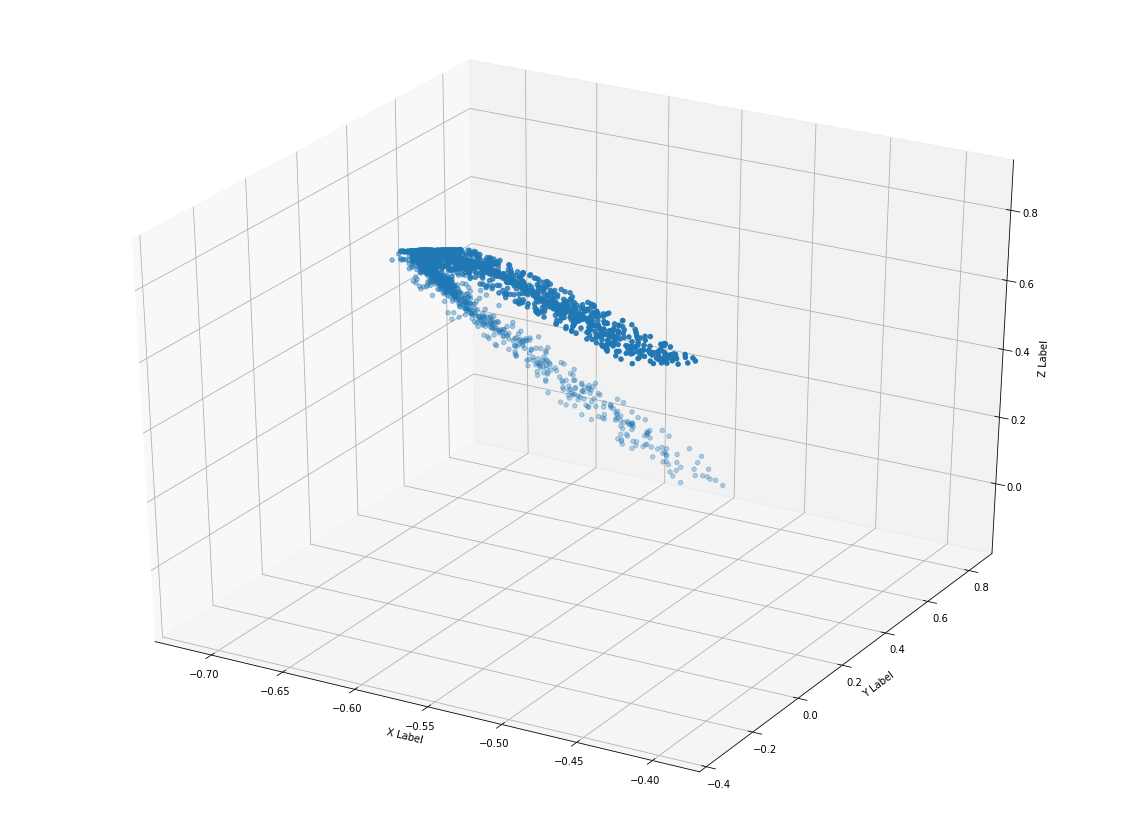

In [11]:
fig = plt.figure(figsize = (20,15))
ax = fig.add_subplot(111, projection='3d')

xs_gd1 = dataset_gd3_subset.x
ys_gd1 = dataset_gd3_subset.y
zs_gd1 = dataset_gd3_subset.z

ax.scatter(xs_gd1, ys_gd1, zs_gd1, marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

Text(0.5, 0, 'Z Label')

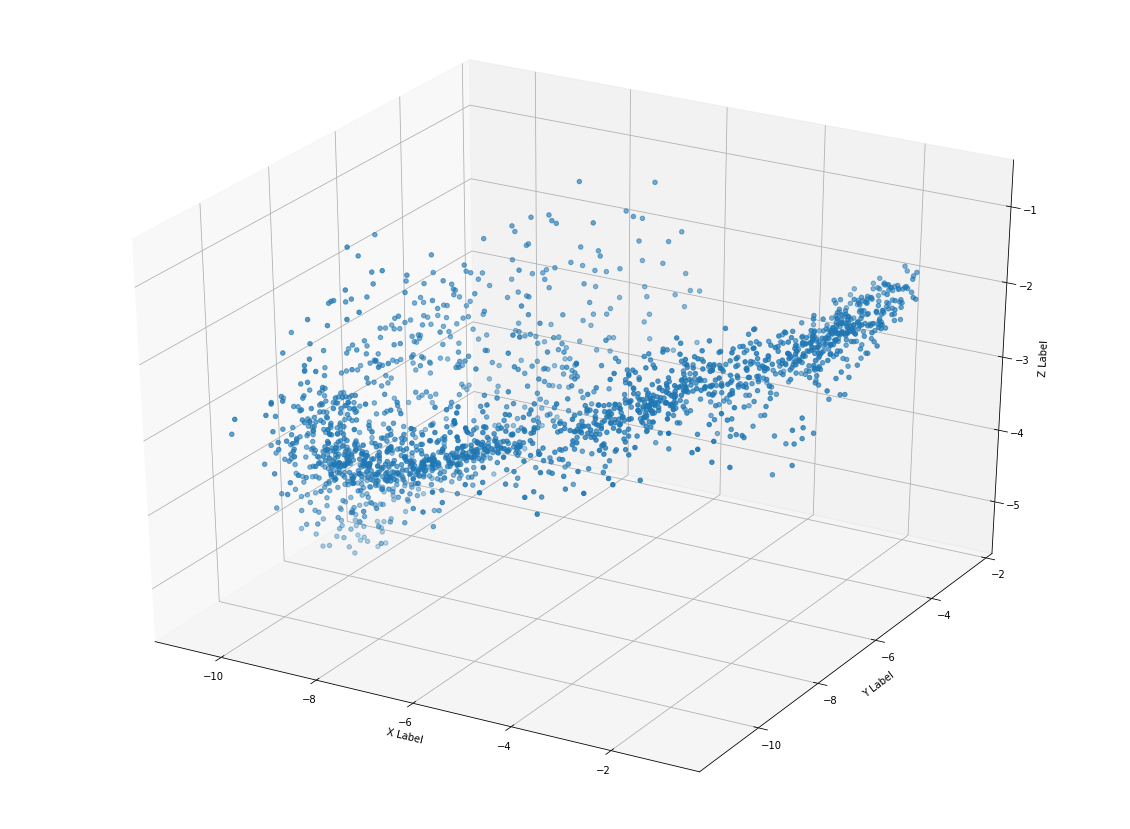

In [39]:
fig = plt.figure(figsize = (20,15))
ax = fig.add_subplot(111, projection='3d')

wx_gd1 = dataset_gd3_subset.wx
wy_gd1 = dataset_gd3_subset.wy
wz_gd1 = dataset_gd3_subset.wz

ax.scatter(wx_gd1, wy_gd1, wz_gd1, marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

Text(0.5, 0, 'Z Label')

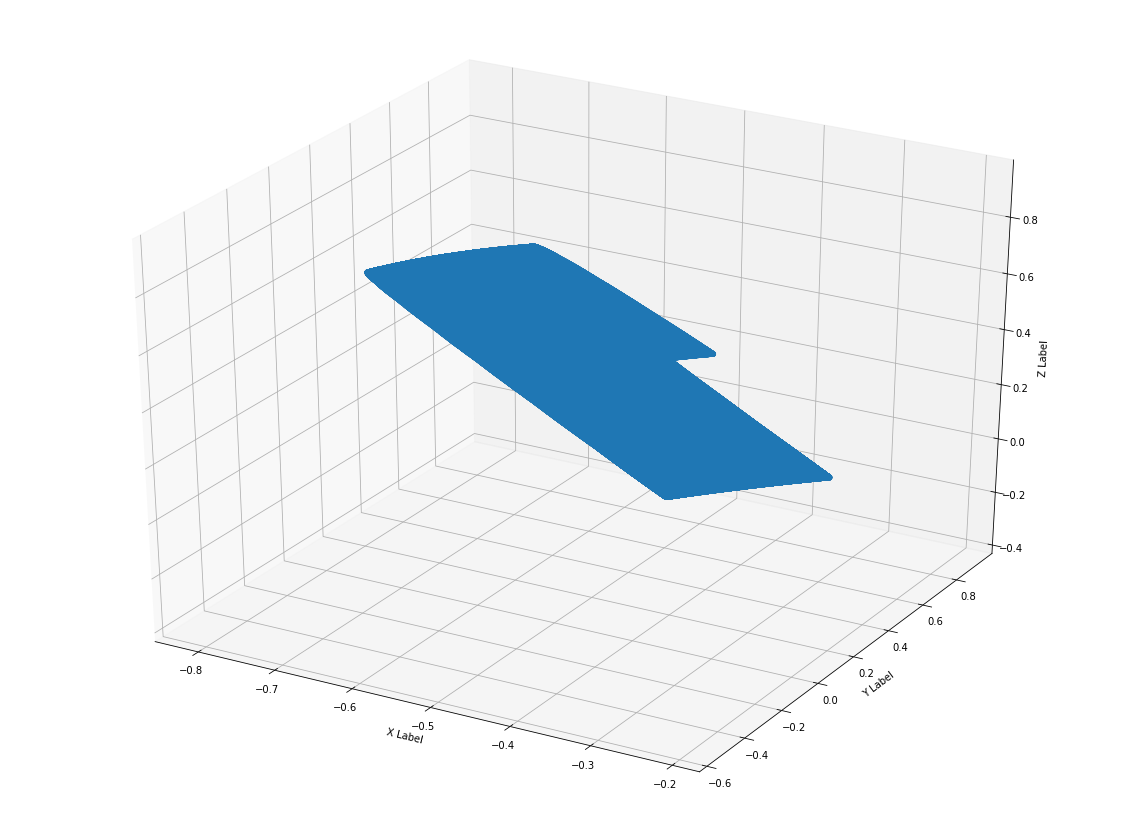

In [12]:
fig = plt.figure(figsize = (20,15))
ax = fig.add_subplot(111, projection='3d')

xs = dataset.x
ys = dataset.y
zs = dataset.z

ax.scatter(xs, ys, zs, marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

Text(0.5, 0, 'Z Label')

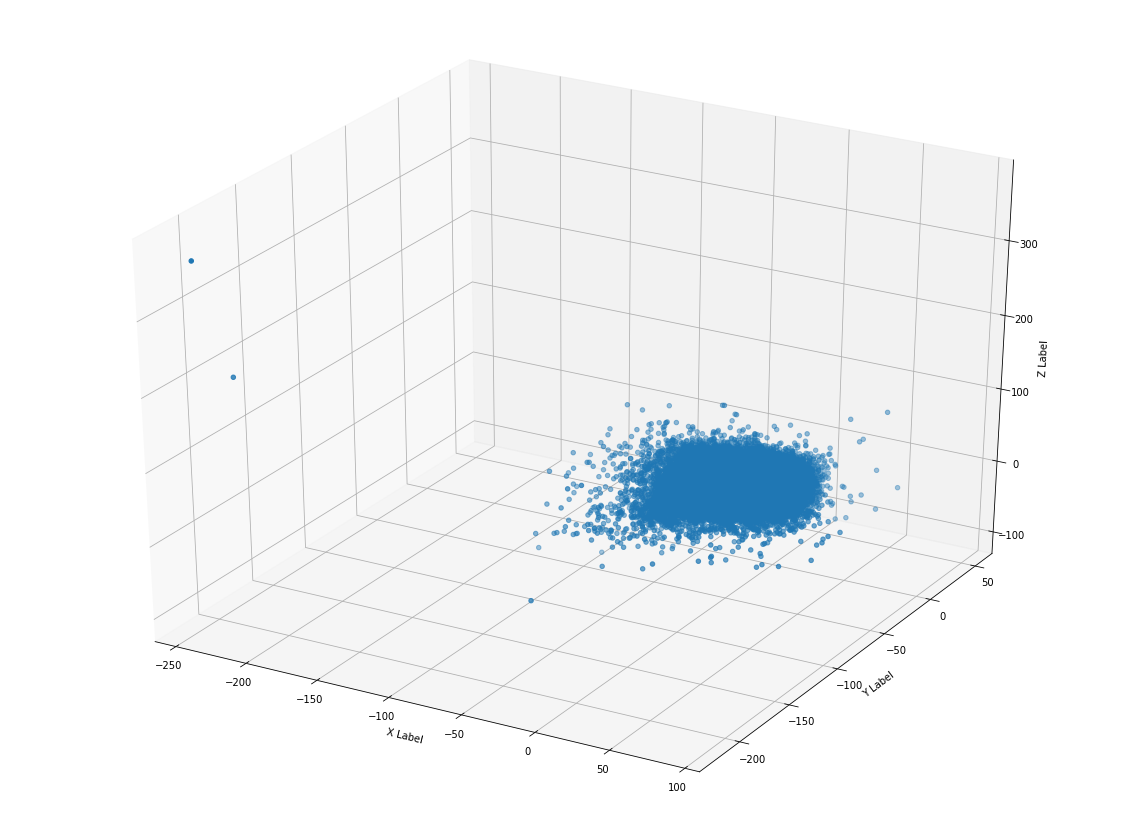

In [29]:
fig = plt.figure(figsize = (20,15))
ax = fig.add_subplot(111, projection='3d')

wx = dataset.wx
wy = dataset.wy
wz = dataset.wz

ax.scatter(wx, wy, wz, marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

In [ ]:

#Visualize all our data points positionally
#Let us use blue markers for our GD1 stars and red markers for our non-GD1 stars
fig = plt.figure(figsize = (20,15))
ax = fig.add_subplot(111, projection='3d')

xs = dataset_nongd.x
ys = dataset_nongd.y
zs = dataset_nongd.z
xs_gd1 = dataset_gd3_subset.x
ys_gd1 = dataset_gd3_subset.y
zs_gd1 = dataset_gd3_subset.z

plt.scatter(xs, ys, zs, marker='o', color = 'r')
plt.scatter(xs_gd1, ys_gd1, zs_gd1, marker='o', color = 'b')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')



Text(0.5, 0, 'Z Label')

In [27]:
dataset_nongd_sample = dataset_nongd.sample(5000)

Text(0.5, 0, 'Z Label')

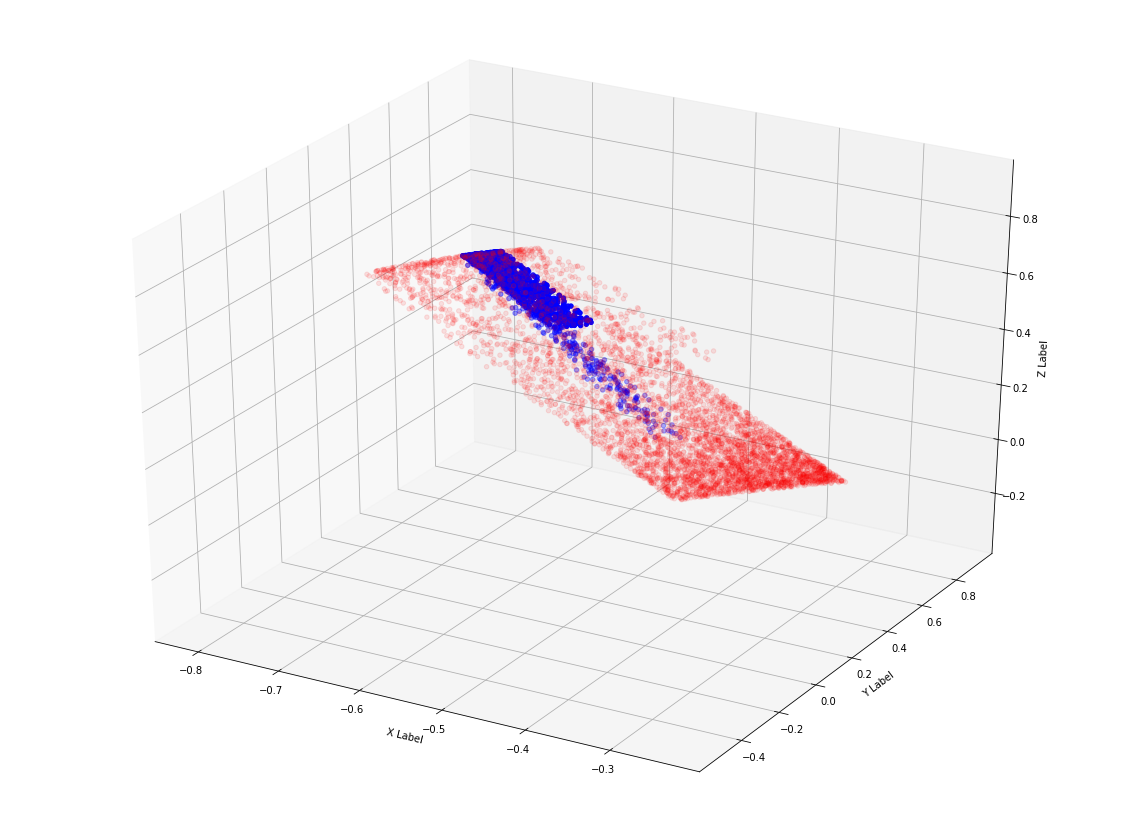

In [28]:
#Visualize all our data points positionally
#Let us use blue markers for our GD1 stars and red markers for our non-GD1 stars
fig = plt.figure(figsize = (20,15))
ax = fig.add_subplot(111, projection='3d')

xs = dataset_nongd_sample.x
ys = dataset_nongd_sample.y
zs = dataset_nongd_sample.z
xs_gd1 = dataset_gd3_subset.x
ys_gd1 = dataset_gd3_subset.y
zs_gd1 = dataset_gd3_subset.z

ax.scatter(xs, ys, zs, color = 'r', alpha = 0.1, zorder = 5)
ax.scatter(xs_gd1, ys_gd1, zs_gd1, color = 'b', zorder = 10)


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

(array([0.00050314, 0.00146368, 0.00507714, 0.00658657, 0.01230407,
        0.01637493, 0.02300724, 0.03343597, 0.04061715, 0.05452212,
        0.06014815, 0.07258944, 0.08059394, 0.08827827, 0.09953032,
        0.10662002, 0.11956445, 0.12491604, 0.13461292, 0.14586497,
        0.15780312, 0.1594955 , 0.16187399, 0.16626503, 0.16388655,
        0.15199414, 0.13854657, 0.12583084, 0.11009627, 0.09555093,
        0.08379575, 0.07615716, 0.07126298, 0.06755803, 0.0727724 ,
        0.0782612 , 0.08827827, 0.10501912, 0.11101107, 0.12404698,
        0.13749455, 0.14430981, 0.14252595, 0.13685419, 0.1301304 ,
        0.11476175, 0.09074823, 0.0511831 , 0.01706103, 0.00173812]),
 array([-11.69109253, -11.46901458, -11.24693664, -11.0248587 ,
        -10.80278075, -10.58070281, -10.35862487, -10.13654693,
         -9.91446898,  -9.69239104,  -9.4703131 ,  -9.24823515,
         -9.02615721,  -8.80407927,  -8.58200132,  -8.35992338,
         -8.13784544,  -7.91576749,  -7.69368955,  -7.47161161

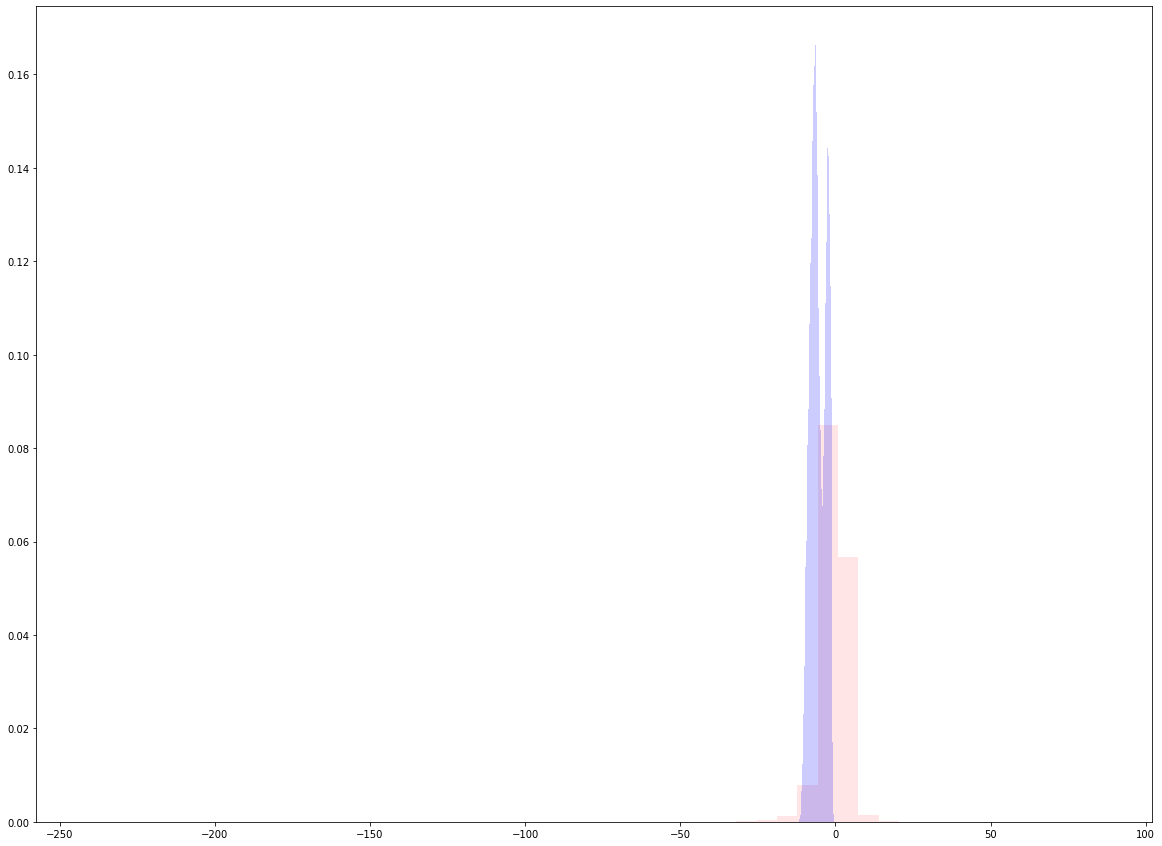

In [52]:
fig = plt.figure(figsize = (20,15))
ax = fig.add_subplot(111)
ax.hist(dataset_nongd.wx, bins = 50, alpha = 0.1, density = 1, color = 'r')
ax.hist(dataset_gd1.wx, bins = 50, density = 1, alpha = 0.2, color = 'b')

In [54]:
dataset_gd1.columns

Index(['source_id_x', 'ra', 'dec', 'parallax_x', 'parallax_error_x', 'pmra_x',
       'pmra_error_x', 'pmdec_x', 'pmdec_error_x', 'ra_parallax_corr',
       'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr',
       'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr',
       'pmra_pmdec_corr', 'visibility_periods_used', 'g',
       'phot_g_mean_flux_over_error', 'bp', 'phot_bp_mean_flux_over_error',
       'rp', 'phot_rp_mean_flux_over_error', 'phot_bp_rp_excess_factor',
       'astrometric_chi2_al_x', 'astrometric_n_good_obs_al_x', 'pm_mask',
       'gi_cmd_mask', 'phi1', 'phi2', 'pm_phi1_cosphi2_no_reflex',
       'pm_phi2_no_reflex', 'pm_phi1_cosphi2', 'pm_phi2', 'stream_track_mask',
       'g_bp', 'g_rp', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'wx', 'wy', 'wz',
       'wrad', 'wtheta', 'wphi', 'bp_rp', 'bp_g', 'phot_g_mean_mag',
       'parallax_y', 'parallax_error_y', 'astrometric_chi2_al_y',
       'astrometric_n_good_obs_al_y', 'source_id_y', 'pmra_y', 'pm

In [56]:
dataset_gd1['bp_rp']

3          1.004353
53         0.808514
86         0.930271
139        1.459881
150        1.853218
             ...   
1415519    1.620321
1415974    0.923386
1415975    0.827048
1416272    0.915518
1416741    1.992775
Name: bp_rp, Length: 98446, dtype: float32